## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [5]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.1/78.2 GB disk)


In [6]:
from ultralytics import YOLO
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4
import shutil

## Data Analysis

In [7]:
data = pd.read_csv('dataset/Training.csv')

In [8]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [9]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


Image path: dataset/Training Images/verymildDem1636.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem876.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem1215.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem1595.jpg
Label: NonDemented
Image path: dataset/Training Images/mildDem424.jpg
Label: MildDemented
Image path: dataset/Training Images/verymildDem870.jpg
Label: VeryMildDemented


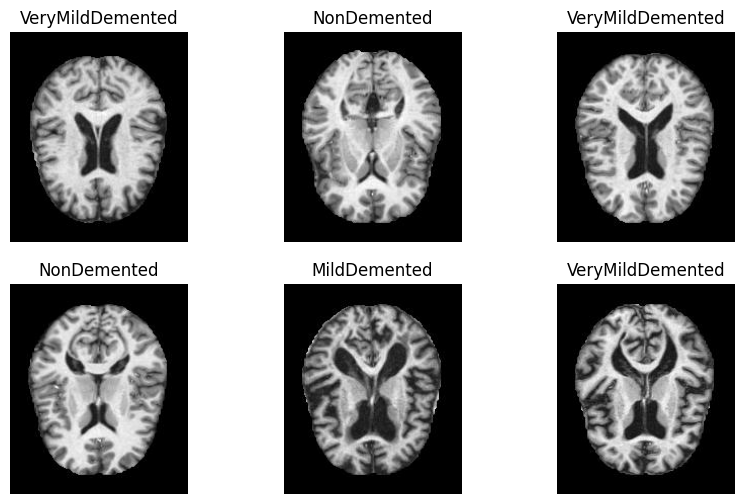

In [10]:
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  
    label = data.loc[idx, 'Label']    

    print("Image path:", im_path)
    print("Label:", label)


    
    img = cv2.imread(im_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Yolo

In [11]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [12]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [13]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [14]:
data.head()

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0


In [16]:
image_counts = data['Label'].value_counts()

print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [17]:
data_limited = pd.DataFrame()  
for label in [2]:
    data_subset = data[data['Label'] == label]
    
    data_subset_sampled = data_subset.sample(n=1800, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])


data_other_labels = data[~data['Label'].isin([2])]
data_limited = pd.concat([data_limited, data_other_labels])

In [18]:
data_limited

,Image,Label
2925,dataset/Training Images/nonDem635.jpg,2
2506,dataset/Training Images/nonDem258.jpg,2
1942,dataset/Training Images/nonDem2053.jpg,2
1247,dataset/Training Images/nonDem1428.jpg,2
2125,dataset/Training Images/nonDem2218.jpg,2
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [19]:
image_counts = data_limited['Label'].value_counts()

print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [20]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)

In [21]:
image_counts = data['Label'].value_counts()

print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [25]:
import pandas as pd
import cv2
import os
from uuid import uuid4
import albumentations as A
from torchvision import transforms as T
from torchvision.transforms import functional as F
import shutil


target_count = 3000

label_counts = data['Label'].value_counts().to_dict()

def apply_augmentations(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.Rotate(limit=(-180, 180), p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomResizedCrop(height=image.shape[0], width=image.shape[1], p=0.5)
    ])
    return transform(image=image)['image']

shutil.rmtree("temp_augmented", ignore_errors=True)
os.makedirs("temp_augmented", exist_ok=True)

augmented_images = []

for label, count in label_counts.items():
    current_count = count
    augmentations_needed = max(0, (target_count - current_count) // current_count) + 1
    label_data = data[data['Label'] == label]

    for _, row in label_data.iterrows():
        img_path = row['Image']
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image at {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_name = str(uuid4())
        original_img_path = os.path.join("temp_augmented", str(label), f"{img_name}_0.png")
        os.makedirs(os.path.dirname(original_img_path), exist_ok=True)
        cv2.imwrite(original_img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        augmented_images.append({'Image': original_img_path, 'Label': str(label)})

        for i in range(augmentations_needed):
            augmented_img = apply_augmentations(img)
            augmented_img_path = os.path.join("temp_augmented", str(label), f"{img_name}_{i+1}.png")
            cv2.imwrite(augmented_img_path, augmented_img)
            augmented_images.append({'Image': augmented_img_path, 'Label': str(label)})

            if len(augmented_images) // len(label_counts) >= target_count:
                break

augmented_df = pd.DataFrame(augmented_images)
augmented_df.to_csv('augmented_dataset.csv', index=False)
print("Augmented dataset created with balanced classes.")



Augmented dataset created with balanced classes.


In [26]:
image_counts = augmented_df['Label'].value_counts()

print(image_counts)

Label
2    3600
0    3585
3    3584
1    1291
Name: count, dtype: int64


In [27]:
train_df, val_df = train_test_split(augmented_df, train_size=0.85, stratify=augmented_df['Label'])


In [28]:
def organize_dataset(df, dataset_type):
    for _, row in df.iterrows():
        src = row['Image']
        dst_dir = os.path.join("datasets", "project", dataset_type, row['Label'])
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src, dst_dir)

!rm -rf datasets/project  
organize_dataset(train_df, 'train')
organize_dataset(val_df, 'val')


In [29]:
import os
import shutil

dataset_path = '/content/datasets/project'

testing_images_path = '/content/dataset/Testing Images'

test_path = os.path.join(dataset_path, 'test')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    for i in range(4):  
        os.makedirs(os.path.join(test_path, str(i)))


class_mapping = {
    'NonDemented': '2',
    'VeryMildDemented': '3',
    'MildDemented': '0',
    'ModerateDemented': '1'
}

for class_folder, class_label in class_mapping.items():
    src_folder_path = os.path.join(testing_images_path, class_folder)
    dst_folder_path = os.path.join(test_path, class_label)

    if os.path.exists(src_folder_path):
        for filename in os.listdir(src_folder_path):
            src_file_path = os.path.join(src_folder_path, filename)
            dst_file_path = os.path.join(dst_folder_path, filename)
            shutil.move(src_file_path, dst_file_path)

print('Test dataset has been organized into class-labeled folders.')


Test dataset has been organized into class-labeled folders.


In [30]:
!ls datasets/project/train/0 | wc
!ls datasets/project/train/1 | wc
!ls datasets/project/train/2 | wc
!ls datasets/project/train/3 | wc
!ls datasets/project/val/0 | wc
!ls datasets/project/val/1 | wc
!ls datasets/project/val/2 | wc
!ls datasets/project/val/3 | wc
!ls datasets/project/test/0 | wc
!ls datasets/project/test/1 | wc
!ls datasets/project/test/2 | wc
!ls datasets/project/test/3 | wc

   3047    3047  131021
   1097    1097   48025
   3060    3060  131580
   3047    3047  131021
    538     538   23134
    194     194    8499
    540     540   23220
    537     537   23091
    179     351    2065
     12      18     108
    640    1273    7604
    448     889    5293


In [31]:
model = YOLO('yolov8n-cls.pt')

100%|██████████| 5.30M/5.30M [00:00<00:00, 105MB/s]


In [61]:
results = model.train(data='datasets/project', epochs=12, device='cuda')

Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=datasets/project, epochs=12, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/datasets/project/train... 10251 images, 0 corrupt: 100%|██████████| 10251/10251 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/project/val... 1809 images, 0 corrupt: 100%|██████████| 1809/1809 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train23
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.70it/s]

                   all      0.591          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  8.09it/s]

                   all      0.609          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.90it/s]

                   all      0.589          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:08<00:00,  6.73it/s]

                   all      0.578          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:08<00:00,  6.68it/s]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.86it/s]

                   all      0.647          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  9.02it/s]

                   all      0.663          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.48it/s]

                   all      0.672          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.76it/s]

                   all      0.717          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.401G     0.7158         11        224: 100%|██████████| 641/641 [01:22<00:00,  7.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.53it/s]


                   all      0.718          1

      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.401G     0.6977         11        224: 100%|██████████| 641/641 [01:19<00:00,  8.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:08<00:00,  6.86it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.516G     0.6716         11        224: 100%|██████████| 641/641 [01:21<00:00,  7.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  8.10it/s]

                   all      0.757          1



12 epochs completed in 0.324 hours.
Optimizer stripped from runs/classify/train23/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train23/weights/best.pt, 3.0MB

Validating runs/classify/train23/weights/best.pt...
Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/datasets/project/train... found 10251 images in 4 classes ✅ 
val: /content/datasets/project/val... found 1809 images in 4 classes ✅ 
test: /content/datasets/project/test... found 1279 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.50it/s]


                   all      0.757          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train23
Results saved to runs/classify/train23


In [62]:
results1 = model.eval()
print(results1)

Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=datasets/project, epochs=12, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train232, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/datasets/project/train... 10251 images, 0 corrupt: 100%|██████████| 10251/10251 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/project/val... 1809 images, 0 corrupt: 100%|██████████| 1809/1809 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train232
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.93it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:08<00:00,  7.08it/s]

                   all      0.683          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.57it/s]

                   all      0.663          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.49it/s]

                   all      0.642          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.79it/s]

                   all      0.673          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.59it/s]

                   all      0.718          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.51it/s]

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.50it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.89it/s]

                   all      0.758          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.382G     0.5677         11        224: 100%|██████████| 641/641 [01:22<00:00,  7.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.46it/s]

                   all      0.767          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.382G     0.5597         11        224: 100%|██████████| 641/641 [01:24<00:00,  7.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:06<00:00,  8.58it/s]

                   all      0.787          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.382G     0.5472         11        224: 100%|██████████| 641/641 [01:22<00:00,  7.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.71it/s]

                   all      0.776          1



12 epochs completed in 0.311 hours.
Optimizer stripped from runs/classify/train232/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train232/weights/best.pt, 3.0MB

Validating runs/classify/train232/weights/best.pt...
Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/datasets/project/train... found 10251 images in 4 classes ✅ 
val: /content/datasets/project/val... found 1809 images in 4 classes ✅ 
test: /content/datasets/project/test... found 1279 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:07<00:00,  7.49it/s]


                   all      0.786          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train232
Results saved to runs/classify/train232
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0f2813de70>
curves: []
curves_results: []
fitness: 0.893034815788269
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7860696315765381, 'metrics/accuracy_top5': 1.0, 'fitness': 0.893034815788269}
save_dir: PosixPath('runs/classify/train232')
speed: {'preprocess': 0.09638950797060433, 'inference': 0.4973142696652642, 'loss': 0.0005796378722435996, 'postprocess': 0.0006538389004548654}
task: 'classify'
top1: 0.7860696315765381
top5: 1.0


In [63]:
results = model.val()

Ultralytics YOLOv8.2.8 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/datasets/project/train... found 10251 images in 4 classes ✅ 
val: /content/datasets/project/val... found 1809 images in 4 classes ✅ 
test: /content/datasets/project/test... found 1279 images in 4 classes ✅ 


val: Scanning /content/datasets/project/val... 1809 images, 0 corrupt: 100%|██████████| 1809/1809 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 114/114 [00:07<00:00, 15.22it/s]


                   all      0.786          1
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2322


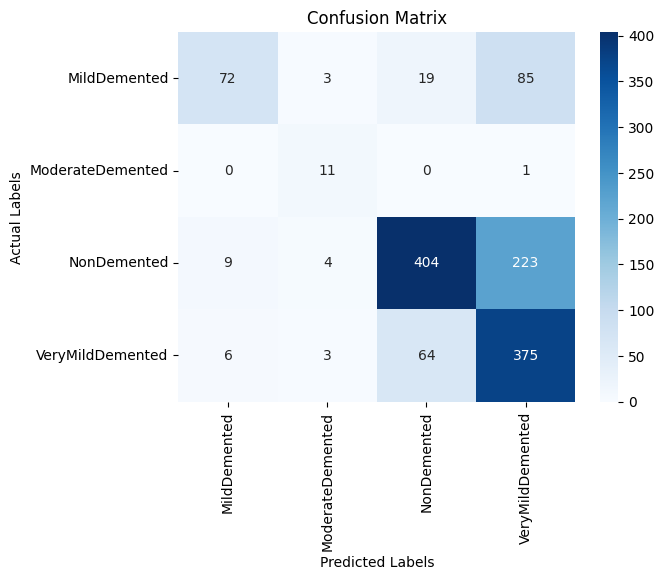

In [80]:
conf_matrix = confusion_matrix(results_df['Actual ID'].astype(int), results_df['Predicted Label'].astype(int))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

## Inference on TestSet

In [35]:
testset = pd.read_csv('dataset/Testing.csv')
testset.Image = testset.Image.map(lambda x: f'dataset/Testing Image/{x}')

testset.head()

,Image,Label
0,dataset/Testing Image/26 (19).jpg,MildDemented
1,dataset/Testing Image/26 (20).jpg,MildDemented
2,dataset/Testing Image/26 (21).jpg,MildDemented
3,dataset/Testing Image/26 (22).jpg,MildDemented
4,dataset/Testing Image/26 (23).jpg,MildDemented


In [36]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'
!unzip -qo "{dataset_path}" -d "./dataset2"

In [37]:
import os
import pandas as pd

def create_image_csv(base_path, output_csv):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    labels_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    images_data = []

    for folder in labels_folders:
        folder_path = os.path.join(base_path, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder, img_file)  
            images_data.append({'Image': img_path, 'Label': folder})

    
    df = pd.DataFrame(images_data)
    df.to_csv(output_csv, index=False)
    print(f"CSV created with {len(images_data)} entries.")


create_image_csv('dataset2/Testing Images', 'testing_images.csv')

CSV created with 1279 entries.


In [38]:
testset = pd.read_csv('testing_images.csv')
testset['Image'] = testset['Image'].map(lambda x: os.path.join('dataset2/Testing Images', x))

testset.head()

,Image,Label
0,dataset2/Testing Images/ModerateDemented/30 (2...,ModerateDemented
1,dataset2/Testing Images/ModerateDemented/30.jpg,ModerateDemented
2,dataset2/Testing Images/ModerateDemented/28.jpg,ModerateDemented
3,dataset2/Testing Images/ModerateDemented/27 (2...,ModerateDemented
4,dataset2/Testing Images/ModerateDemented/27.jpg,ModerateDemented


In [ ]:


pred = {}
for x in testset.Image:
  res = model(x)
  pred[x] = res

In [40]:
base_path = 'dataset2/Testing Images'
labels_folders = os.listdir(base_path)


test_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        test_images.append((img_path, folder))

original_df = pd.DataFrame(test_images, columns=['Image', 'Label'])

In [41]:
original_df

,Image,Label
0,dataset2/Testing Images/ModerateDemented/30 (2...,ModerateDemented
1,dataset2/Testing Images/ModerateDemented/30.jpg,ModerateDemented
2,dataset2/Testing Images/ModerateDemented/28.jpg,ModerateDemented
3,dataset2/Testing Images/ModerateDemented/27 (2...,ModerateDemented
4,dataset2/Testing Images/ModerateDemented/27.jpg,ModerateDemented
...,...,...
1274,dataset2/Testing Images/MildDemented/28 (12).jpg,MildDemented
1275,dataset2/Testing Images/MildDemented/28 (13).jpg,MildDemented
1276,dataset2/Testing Images/MildDemented/32.jpg,MildDemented
1277,dataset2/Testing Images/MildDemented/32 (28).jpg,MildDemented


In [42]:
df = pd.DataFrame({'Image': pred.keys(), 'Label': pred.values()})

In [43]:
df.Label = df.Label.map(lambda x: x[0].probs.data.argmax().cpu().item())

In [44]:
id2label = model.names

In [45]:
df.Label = df.Label.map(lambda x: id2label[x])

In [46]:
df.head()

,Image,Label
0,dataset2/Testing Images/ModerateDemented/30 (2...,1
1,dataset2/Testing Images/ModerateDemented/30.jpg,3
2,dataset2/Testing Images/ModerateDemented/28.jpg,1
3,dataset2/Testing Images/ModerateDemented/27 (2...,1
4,dataset2/Testing Images/ModerateDemented/27.jpg,1


In [57]:

results_df = pd.merge(original_df, df, on='Image', how='left')

results_df.columns = ['Image', 'Actual Label', 'Predicted Label']

print(results_df)

                                                  Image      Actual Label  \
0     dataset2/Testing Images/ModerateDemented/30 (2...  ModerateDemented   
1       dataset2/Testing Images/ModerateDemented/30.jpg  ModerateDemented   
2       dataset2/Testing Images/ModerateDemented/28.jpg  ModerateDemented   
3     dataset2/Testing Images/ModerateDemented/27 (2...  ModerateDemented   
4       dataset2/Testing Images/ModerateDemented/27.jpg  ModerateDemented   
...                                                 ...               ...   
1274   dataset2/Testing Images/MildDemented/28 (12).jpg      MildDemented   
1275   dataset2/Testing Images/MildDemented/28 (13).jpg      MildDemented   
1276        dataset2/Testing Images/MildDemented/32.jpg      MildDemented   
1277   dataset2/Testing Images/MildDemented/32 (28).jpg      MildDemented   
1278   dataset2/Testing Images/MildDemented/32 (15).jpg      MildDemented   

     Predicted Label  
0                  1  
1                  3  
2     

In [58]:
results_df

,Image,Actual Label,Predicted Label
0,dataset2/Testing Images/ModerateDemented/30 (2...,ModerateDemented,1
1,dataset2/Testing Images/ModerateDemented/30.jpg,ModerateDemented,3
2,dataset2/Testing Images/ModerateDemented/28.jpg,ModerateDemented,1
3,dataset2/Testing Images/ModerateDemented/27 (2...,ModerateDemented,1
4,dataset2/Testing Images/ModerateDemented/27.jpg,ModerateDemented,1
...,...,...,...
1274,dataset2/Testing Images/MildDemented/28 (12).jpg,MildDemented,0
1275,dataset2/Testing Images/MildDemented/28 (13).jpg,MildDemented,2
1276,dataset2/Testing Images/MildDemented/32.jpg,MildDemented,3
1277,dataset2/Testing Images/MildDemented/32 (28).jpg,MildDemented,2


In [59]:

label2id = {'MildDemented':'0',
 'ModerateDemented':'1',
'NonDemented':'2',
 'VeryMildDemented':'3'}

# Apply mapping
results_df['Actual ID'] = results_df['Actual Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label']


results_df


,Image,Actual Label,Predicted Label,Actual ID,Predicted ID
0,dataset2/Testing Images/ModerateDemented/30 (2...,ModerateDemented,1,1,1
1,dataset2/Testing Images/ModerateDemented/30.jpg,ModerateDemented,3,1,3
2,dataset2/Testing Images/ModerateDemented/28.jpg,ModerateDemented,1,1,1
3,dataset2/Testing Images/ModerateDemented/27 (2...,ModerateDemented,1,1,1
4,dataset2/Testing Images/ModerateDemented/27.jpg,ModerateDemented,1,1,1
...,...,...,...,...,...
1274,dataset2/Testing Images/MildDemented/28 (12).jpg,MildDemented,0,0,0
1275,dataset2/Testing Images/MildDemented/28 (13).jpg,MildDemented,2,0,2
1276,dataset2/Testing Images/MildDemented/32.jpg,MildDemented,3,0,3
1277,dataset2/Testing Images/MildDemented/32 (28).jpg,MildDemented,2,0,2


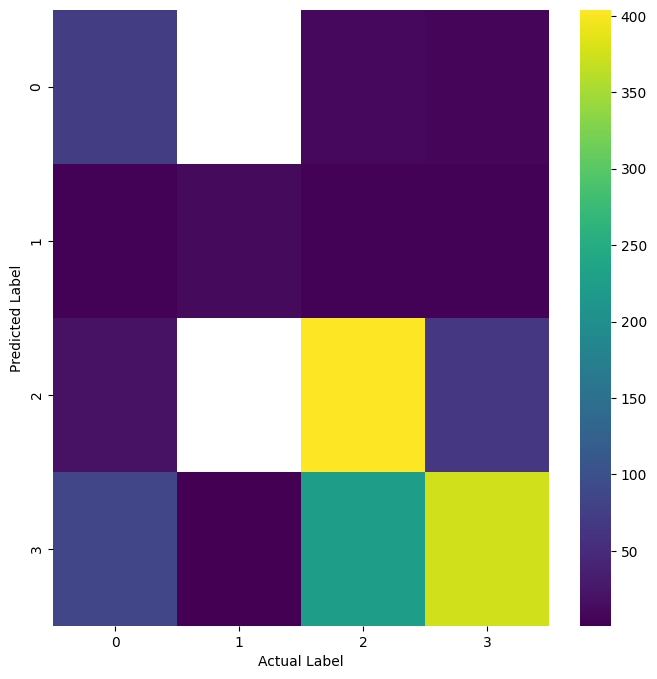

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Predicted Label'].value_counts()
    for x_label, grp in results_df.groupby('Actual ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Actual Label')
_ = plt.ylabel('Predicted Label')

In [60]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label2id = {'0':0,
'1':1,
'2':2,
'3':3}

results_df['Actual ID'] = results_df['Actual ID'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)
accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')  # weighted for imbalanced classes

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.6739640344018765
F1 Score: 0.6728448309184915
